## Setting

In [173]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/gdrive/My Drive/Colab Notebooks/Pytorch_study')

In [0]:
%matplotlib inline

In [176]:
!ls data/cifar-10-batches-py

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [0]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, utils

from torch import nn
import torch.nn.functional as F
from torch import optim



# Data Load

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
path = './data/cifar-10-batches-py/'
path = os.path.join(path, 'data_batch_1')

batch1 = unpickle(path)

In [180]:
len(batch1[b'data'])

10000

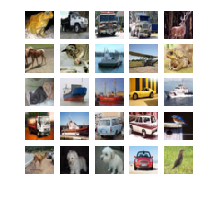

In [181]:
X = batch1[b"data"] 
Y = batch1[b'labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0], interpolation='nearest')


In [182]:
# label names
path = './data/cifar-10-batches-py/batches.meta'
label_name = unpickle(path)
label_name[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

## Dataset Class

In [0]:
class cf10_dataset(Dataset):
    """cifar10 dataset."""
    def __init__(self, batch_name, transform=None):
        """
        Args:
            batch_name (string): batch file name
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        path = './data/cifar-10-batches-py/'
        
        path = os.path.join(path, batch_name)
        self.batch = unpickle(path)                            
        self.transform = transform
        
    def __len__(self):
        return len(self.batch[b'data'])
    
    def __getitem__(self, idx):
        image = self.batch[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")[idx]
        label = np.array(self.batch[b'labels'])[idx]
        sample = (image, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

4


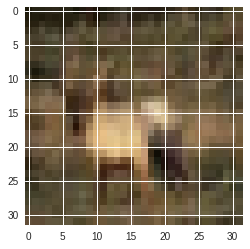

In [185]:
# image 확인
dataset = cf10_dataset('data_batch_1')
item = dataset.__getitem__(3)

plt.imshow(item[0], interpolation='nearest')
print(item[1])

## Transforms

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return (torch.from_numpy(image).float(), label)

## Torchvision 사용하는 경우

In [0]:
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainset.__getitem__(0)

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

# Model

## CNN Model Class

In [0]:
class cf10_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) 
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1) # (32-3+2)/1+1 = 32
        self.conv2 = nn.Conv2d(18,18, kernel_size=3, stride=1, padding=1) # (32-3+2)/1+1 = 32
        self.conv3 = nn.Conv2d(18,10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(10*16*16, 10)
       
        
    def forward(self, xb):
#         print(xb)
        xb = xb.view(-1, 3, 32, 32)
        xb = F.relu(self.conv1(xb))
#         print(xb.shape)
        xb = F.relu(self.conv2(xb))
#         print(xb.shape)
        xb = self.pool(F.relu(self.conv3(xb)))
#         print(xb.shape)        
        xb = xb.view(-1, 10*16*16)
        xb = self.fc1(xb)
#         print(xb.shape)
        return xb
    
lr = 0.1

## Optimization, Loss

In [0]:
model = cf10_cnn()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy

# Training

## DataLoader

In [0]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

bs = 128

train_ds1 = cf10_dataset('data_batch_1', transform=ToTensor())
train_ds2 = cf10_dataset('data_batch_2', transform=ToTensor())
train_ds3 = cf10_dataset('data_batch_3', transform=ToTensor())
train_ds4 = cf10_dataset('data_batch_4', transform=ToTensor())
train_ds = ConcatDataset((train_ds1, train_ds2, train_ds3, train_ds4))
valid_ds = cf10_dataset('test_batch', transform=ToTensor())

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

## fit() 

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward() ## backprop
        opt.step() ## weight update
        
        # print statistics
        opt.zero_grad() ## gradient initialize

    return loss.item(), len(xb)

In [0]:
#  fit runs the necessary operations to train our model and compute the training and validation losses for each epoch.
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for i, (xb, yb) in enumerate(train_dl):
            losses, num = loss_batch(model, loss_func, xb, yb, opt)
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                     (epoch + 1, i+1, np.sum(losses)/num ))

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl] ## *연산자에 대한 이해가 부족해....
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

## GPU Setting

In [195]:
print(torch.cuda.is_available())

True


In [0]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
## Data to GPU
def preprocess(x,y):
    return x.view(-1,1,32,32).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

            
# data to GPU
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


# model to GPU
model.to(dev)


## Training

In [0]:
# training
epochs = 10
# train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

[1,   100] loss: 0.006
[1,   200] loss: 0.006
[1,   300] loss: 0.006
0 2.304640351867676
[2,   100] loss: 0.006
[2,   200] loss: 0.006
[2,   300] loss: 0.006
1 2.30361224899292
[3,   100] loss: 0.006
[3,   200] loss: 0.006
[3,   300] loss: 0.006
2 2.303916249465942
[4,   100] loss: 0.006
[4,   200] loss: 0.006
[4,   300] loss: 0.006
3 2.3044961669921875
[5,   100] loss: 0.006
[5,   200] loss: 0.006
[5,   300] loss: 0.006
4 2.303637121963501
[6,   100] loss: 0.006
